# Vision Transformer (ViT)
This notebook replicates the Vision Transformer (ViT) model paper with PyTorch for image classification tasks
> URL: https://arxiv.org/abs/2010.11929

In [1]:
import os
from pathlib import Path

import sys
sys.path.append("../")
from src.utils import get_device, plot_loss_curves
from going_modular import data_setup, engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.notebook import tqdm

print("PyTorch version: ",torch.__version__)
print("Torchvision version: ",torchvision.__version__)

PyTorch version:  2.0.0
Torchvision version:  0.15.1


Hyperparameters

In [2]:
BATCH_SIZE = 32 # The paper uses 4096 which is too big for a normal computer's hardware
NUM_WORKERS = 0 # MPS cannot work with more than 0
EPOCHS = 3
LR = 0.001
SEED = 42
IMG_SIZE = 224 #dimensions used by the ViT paper

Set device

In [3]:
device = get_device()
device

'mps'

Get data

In [4]:
data_path = Path("data/")
train_dir = data_path / "pizza_steak_sushi/train"
test_dir = data_path / "pizza_steak_sushi/test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create datasets and dataloaders

In [5]:
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")
print(f"Class names of interest: {class_names}")

Number of training batches: 8
Number of test batches: 3
Class names of interest: ['pizza', 'steak', 'sushi']


## Visualizing our images

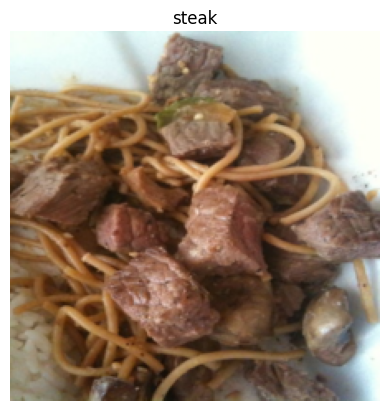

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

## Replicating ViT:
* **Inputs**: Image tensors by batches
* **Outputs**: The predicted classification label
* **Layers**: Takes an input, manipulates it with a function (self-attention)
* **Blocks**: Collection of layers
* **Model**: Collection of blocks

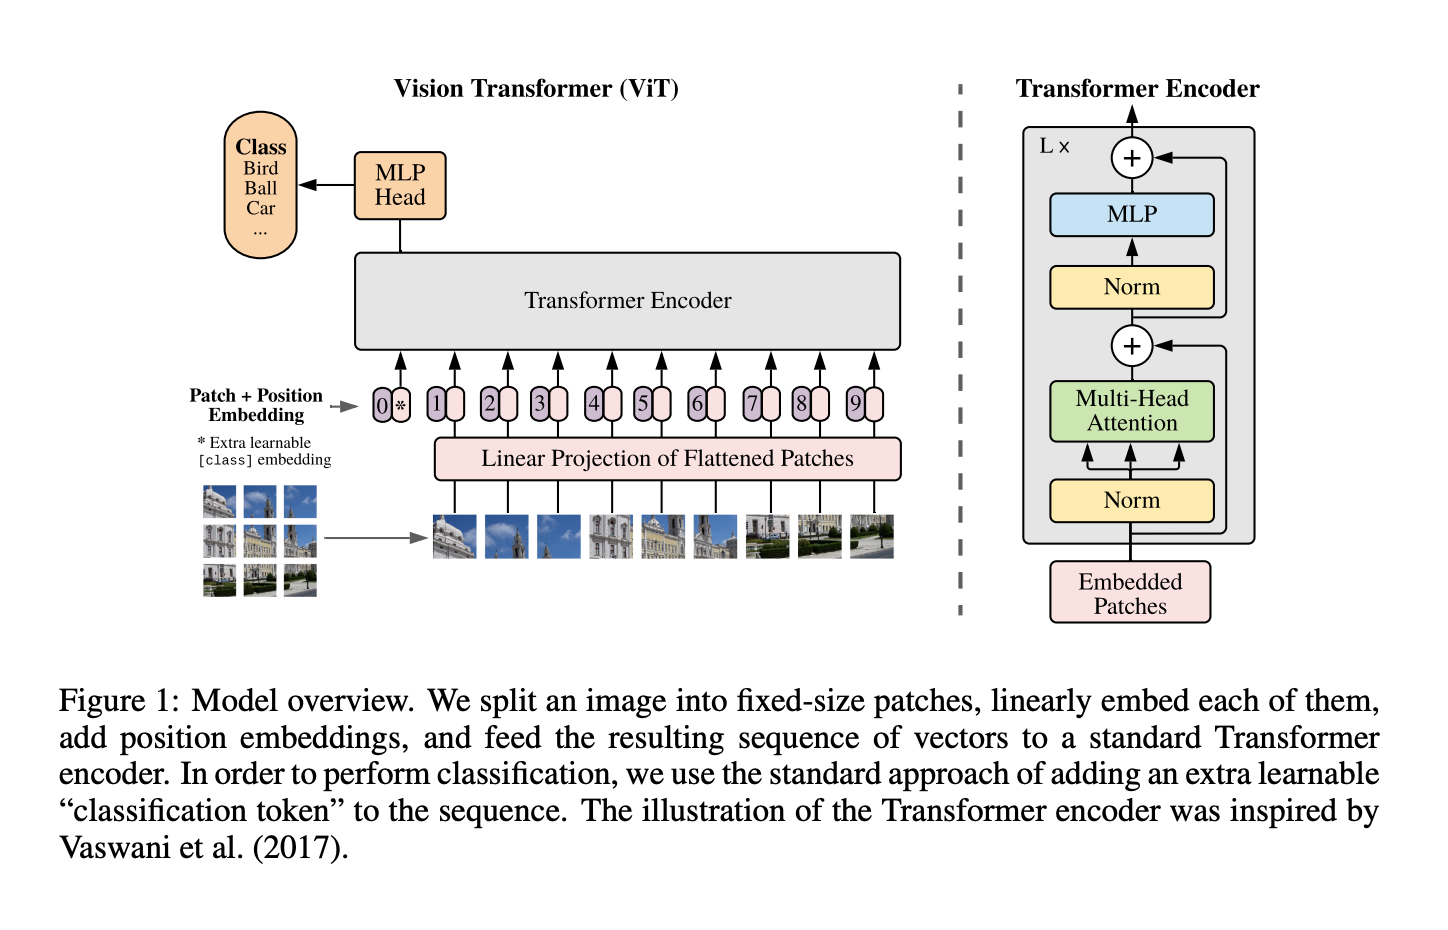

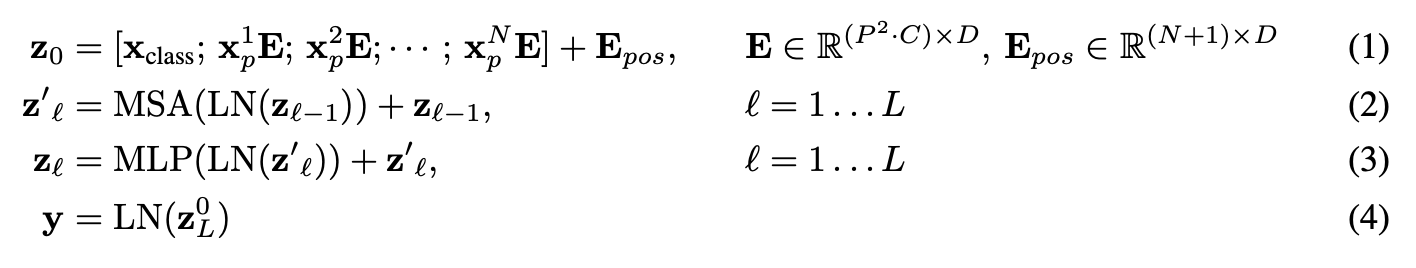

* We need to cut out the image and patch them sequentially like an English sentence (transformers were first conceptualized and applied in NLP). The number of patches in an image (N):
$ N = \frac{HW}{P^2}\ $
* **Equation 1**: 
    *   $z_{0}$ refers to the logits
    *   $x^n_{p}$ refers to patch specific inputs. E refers to the embeddings. The value of $ E \times \Sigma_{n=1}^n x^n_{p} $ refers to the patch embeddings. 
    *   $ E_{pos} $ refers to the positional embeddings of the patches so as to retain positional information
    *   $x_{class}$ refers to the learnable classification token of the entire sequence of patches.
    *   The output of equation 1 is the input into the encoder
* **Equation 2**
    *   $z'_{l}$ refers to the output of the multi-self-attention (MSA) layer.
    *   Layer normalization (LN) is applied to the input of every block.
* **Equation 3**
    *   $z_{l}$ refers to the output of the Multi-layer perceptron (MLP) layer of each transformer encoder block.
    *   There is a residual connection after every block which sums the output of the MSA layer and pre-normalized MSA input. The summed inputs are normalized first before being pushed into the MLP layer, and the pre-normalized inputs are simultaneously piped directly for summation with the output of the MLP layer.
* **Equation 4**
    * Multilayer perceptron refers to multiple feedforward layers
    * Accoding to the paper, at training and finetuning, MLP refers to only 1 hidden layer.

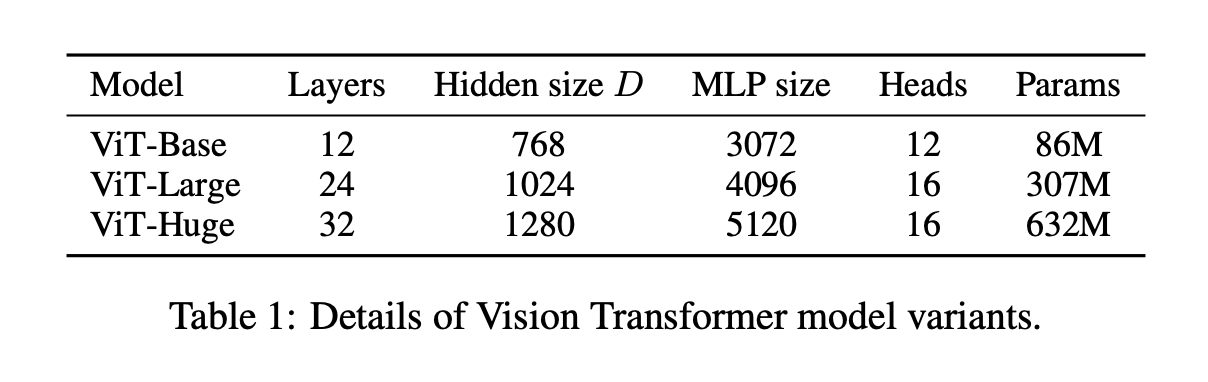
According to the paper. The transformer's sequence length is inversely proportional to the square of the patch size, and therefore models with smaller patch size are computationally more expensive.  
* Layers: Number of transformer encoder layers
* Hidden size $D$: The embedding size throughout the architecture. So a $D$ value of 768 this means that the patches are 16x16
* MLP size: Number of hidden units/neurons in the MLP layer
* Head: Number of multi-head self-attention

## Equation 1: Split data into patches and creating the class, position and patch embedding
* Input shape: $ H\times{W}\times{C} $ = (224, 224, 3)
* Output shape: $ {N \times\left(P^{2} \cdot C\right)}$


Where:
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = $ \frac{HW}{P^2}\ $
* D = constant latent vector size = embedding dimension in Table 1

#### Turning a single image into patches

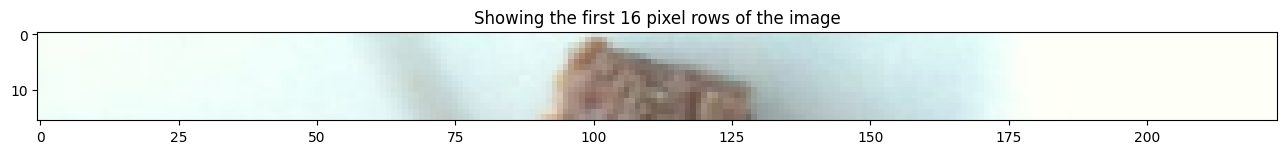

In [14]:
image_permuted = image.permute(1,2,0)
PATCH_SIZE = 16
plt.figure(figsize = (PATCH_SIZE, PATCH_SIZE))
plt.imshow(image_permuted[:PATCH_SIZE, :, :])
plt.title("Showing the first 16 pixel rows of the image")
plt.show()

If we were to patchify this image, we'll be then cutting every 16 pixels on the x-axis

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


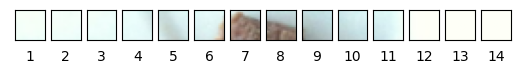

In [17]:
num_patches = IMG_SIZE/PATCH_SIZE
assert IMG_SIZE % PATCH_SIZE == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {PATCH_SIZE} pixels x {PATCH_SIZE} pixels")

fig, axs = plt.subplots(nrows = 1,
                        ncols = int(num_patches), # one column per patch
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    axs[i].imshow(image_permuted[:PATCH_SIZE, #up to row 16
                                 patch: patch + PATCH_SIZE,
                                 :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_yticks([])
    axs[i].set_xticks([])

Patchifying the entire image

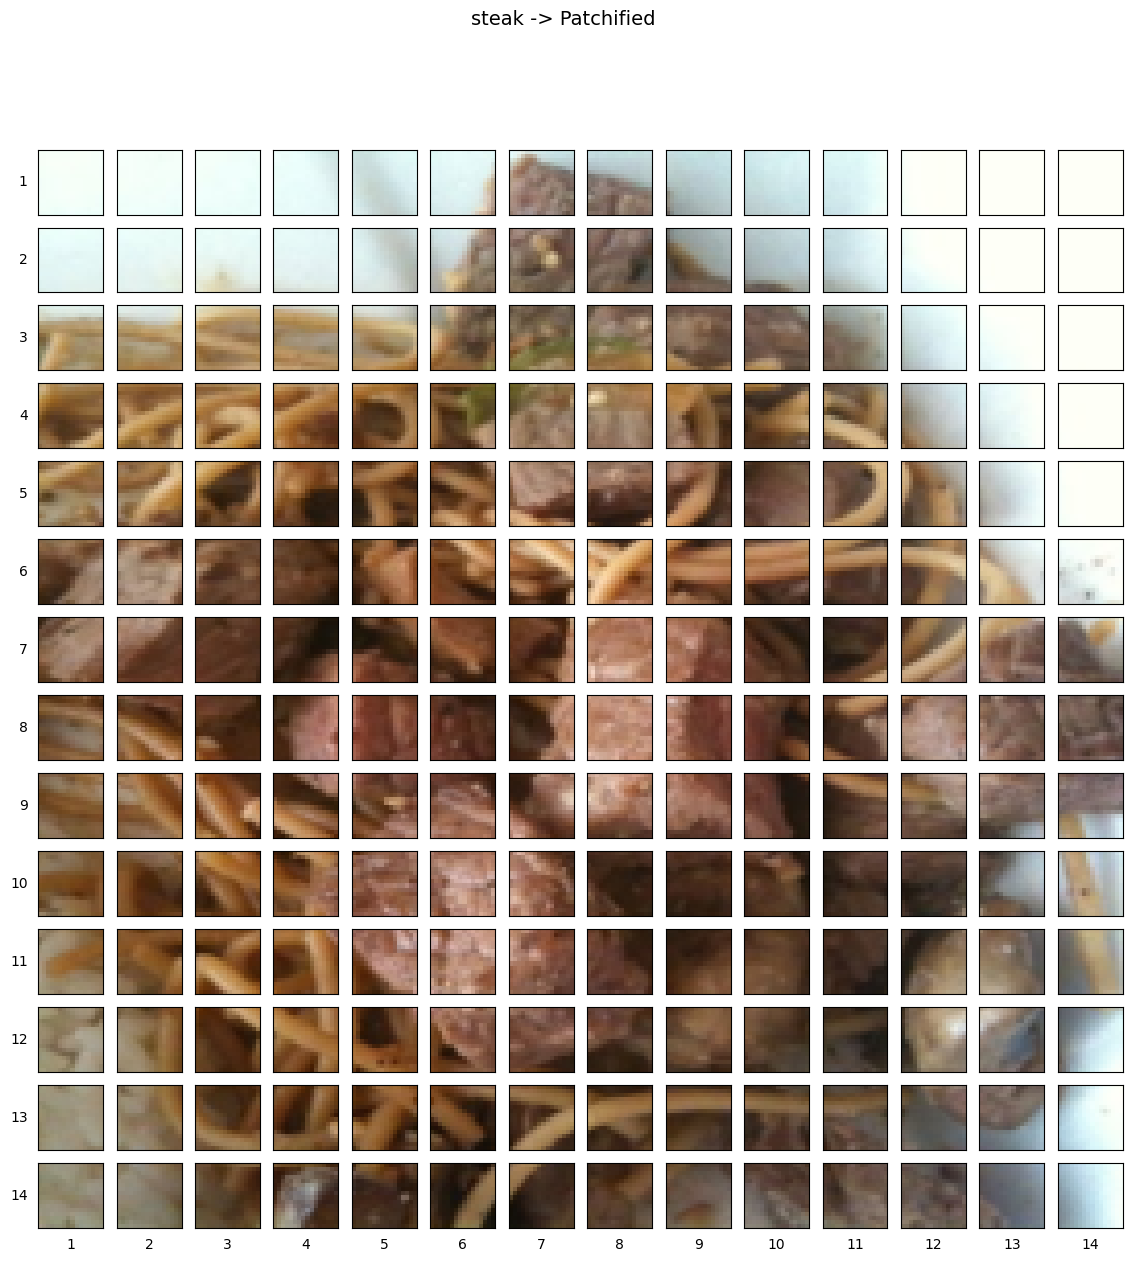

In [19]:
fig, axs = plt.subplots(nrows = int(num_patches),
                        ncols = int(num_patches), # one column per patch
                        figsize = (int(num_patches), int(num_patches)),
                        sharex = True,
                        sharey = True)

for i, patch_height in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    for j, patch_width in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
        axs[i, j].imshow(image_permuted[patch_height: patch_height + PATCH_SIZE,
                                        patch_width: patch_width + PATCH_SIZE,
                                        :])
        axs[i, j].set_ylabel(i+1,
                             rotation = 'horizontal',
                             ha = 'right',
                             verticalalignment = 'center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

#### Now let's use Conv2D to get patch embeddings
Create the image patches and image patch embeddings in a single step by setting the kernel size and stride size to `PATCH_SIZE`

In [21]:
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768, #D size from table 1 for vit-base model
                   kernel_size = PATCH_SIZE,
                   stride = PATCH_SIZE,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Visualize passing a single image through the conv2d layer

In [22]:
img_conv = conv2d(image.unsqueeze(0) #add batch dimension
                  )
img_conv.shape

torch.Size([1, 768, 14, 14])

Passing a single image into our conv2d layer yields the following shape:
```python
torch.size([1, 768, 14, 14]) #[batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Plot raandom feature maps

Showing random convoluational feature maps from indexes: [532, 76, 319, 428, 702]


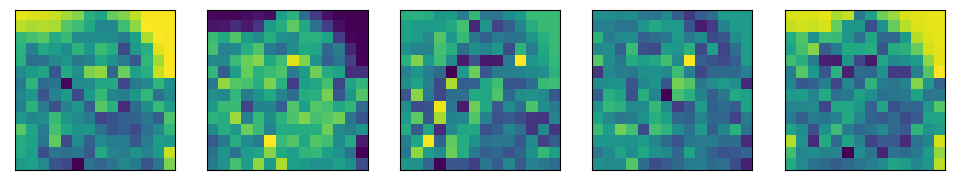

In [24]:
import random
random_idx = random.sample(range(0, 768), k = 5)
print(f"Showing random convoluational feature maps from indexes: {random_idx}")

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12,12))
for i, idx in enumerate(random_idx):
    image_conv_feature_map = img_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks = [], yticks = [])

Flatten the feature maps to get (1, 768, 14*14)

In [33]:
flatten_layer = nn.Flatten(start_dim = 2,
                           end_dim = 3)
flatten_layer(img_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Flattened image feature map shape: torch.Size([1, 768, 196])
Getting a vector: torch.Size([1, 196, 768])


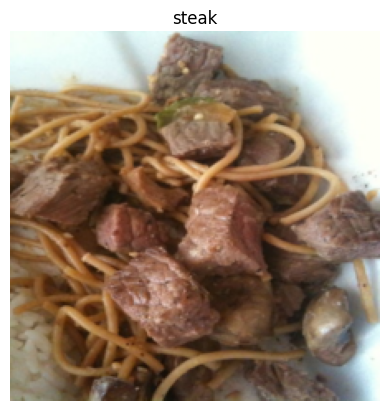

In [37]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")
img_conv = conv2d(image.unsqueeze(0))
img_conv_flattened = flatten_layer(img_conv)
print(f"Flattened image feature map shape: {img_conv_flattened.shape}")
print(f"Getting a vector: {img_conv_flattened.permute(0,2, 1).shape}")

#### Creating the patch embedding layer in PyTorch


In [44]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = PATCH_SIZE, 
                 out_channels: int = 768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = out_channels, #D size from table 1 for vit-base model
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)
    def forward(self, x: np.array):
        """Returns processed image in the order (batch_size, number_of_patches, embedding_dimension)
        """
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by {self.patch_size}"
        return self.flatten(self.patcher(x)).permute(0, 2, 1)

embedder = PatchEmbedding()
img_processed = embedder(image.unsqueeze(0))
img_processed.shape

torch.Size([1, 196, 768])

#### Creating the class token embedding
We want to prepend (add to the front) a learnable class token to the start of the patch embedding - this is the $x_{class}$ variable in equation 1

In [47]:
batch_size = img_processed.shape[0]
embedding_dimension = img_processed.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [49]:
# Create class token embedding as a learnable
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [52]:
# Add class token embedding to the front
img_processed_with_class_embedding = torch.cat((class_token,img_processed),
                                               dim = 1)
print(f"New shape after prepending: {img_processed_with_class_embedding.shape} -> (batch_size, number_of_patches + class_token, embedding_dim)")

New shape after prepending: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches + class_token, embedding_dim)


#### Creating position embeddings

In [55]:
# Calculate number of patches
number_of_patches = int(( IMG_SIZE * IMG_SIZE)/PATCH_SIZE**2)
embedding_dimension = img_processed_with_class_embedding.shape[-1]
number_of_patches, embedding_dimension

(196, 768)

In [57]:
position_embeddings = nn.Parameter(torch.randn(batch_size,
                                               number_of_patches + 1, #match processeed_img_with_class_embeddings dimension
                                               embedding_dimension),
                                   requires_grad = True)
position_embeddings.shape

torch.Size([1, 197, 768])

In [58]:
patch_and_position_embedding = img_processed_with_class_embedding + position_embeddings
patch_and_position_embedding.shape #This will be the input into the transformer encoder

torch.Size([1, 197, 768])

### Putting equation 1 together

In [64]:
torch.manual_seed(SEED)

PATCH_SIZE = 16

print(f"Image tensor shape: {image.shape}") #(3, 224, 224)
height, width = image.shape[1], image.shape[2] 

# Add batch dimension to image
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}") #(1, 3, 224, 224)

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding()
patch_embedding  = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad = True)
patch_class_embedding = torch.cat((class_token,patch_embedding),
                                  dim = 1)
print(f"Patch embedding with class token shape: {patch_class_embedding.shape}")

# Create position embedding
position_embeddings = nn.Parameter(torch.randn(batch_size,
                                               number_of_patches + 1, #match processeed_img_with_class_embeddings dimension
                                               embedding_dimension),
                                   requires_grad = True)
patch_and_position_embedding = img_processed_with_class_embedding + position_embeddings

print(f"Patch embedding with class and position embeddings shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch embedding with class and position embeddings shape: torch.Size([1, 197, 768])


## Equation 2: Multi self-attention

In [70]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0.0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dimension)
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dimension,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first = True #input tensor's 1st dimension is batch
                                                    )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights = False)
        return attn_output

In [72]:
# Test
msa = MultiHeadSelfAttentionBlock()
msa_img = msa(patch_and_position_embedding)
msa_img.shape

torch.Size([1, 197, 768])

In [73]:
msa_img == patch_and_position_embedding

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

The output shape does not change but the values have definitely changed

## Equation 3: Multi-layer perceptron with layer normalization
* The MLP contains 2 layers with GELU non-linearity activation (according to the paper)

In [79]:
class MLP(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim),
            nn.Dropout(p = dropout)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(self.layer_norm(x))

In [82]:
mlp = MLP()
mlp_img = mlp(msa_img)
mlp_img.shape

torch.Size([1, 197, 768])

## Developing the Transformer Encoder
> Putting equations 2 and 3 together including implementing residual (skip) connections